## Potrebni importi

In [1]:
import zipfile
import os
import numpy as np
import pandas as pd
import shutil #za merge foldera
import xml.etree.ElementTree as ET #za xml

## Učitavanje zip datoteka i raspakiravanje

In [2]:
path_to_zip_file = "drive/MyDrive/archive.zip"
directory_to_extract_to = "data/" #ovdje ce zavrsiti sve slike za trening

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [ ]:
#rucno oznacene slike
path_to_second_zip_file = "drive/MyDrive/ZaPklot.zip"
directory_to_extract_to = "data/PKLot/PKLot" #ovdje ce zavrsiti sve slike za trening

alreadyExists=  os.path.exists(directory_to_extract_to)

if alreadyExists is False :
    os.mkdir(directory_to_extract_to)

with zipfile.ZipFile(path_to_second_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

Spoji sve slike iz foldera u 1

In [3]:
# Define your source and destination folders
mysource_folder = "data/PKLot/PKLot"
mydestination_folder = "data/all" #ovdje spremamo sve slike
alreadyExists=  os.path.exists(mydestination_folder)

if alreadyExists is False :
    os.mkdir(mydestination_folder)
    # provjeri je li postoji


# Loop through all files and subdirectories in source folder
for root, dirs, files in os.walk(mysource_folder):

    # Loop through all files in current directory
    for file in files:

        # Create full path for the file
        file_path = os.path.join(root, file)

        # Copy the file to the destination folder
        os.rename(file_path, os.path.join(mydestination_folder, file))

    # Loop through all subdirectories in current directory
    for dir in dirs:

        # Create full path for the subdirectory
        dir_path = os.path.join(root, dir)

        # Copy all files and subdirectories in the subdirectory to the destination folder
        for subroot, subdirs, subfiles in os.walk(dir_path):
            for subfile in subfiles:
                subfile_path = os.path.join(subroot, subfile)

#os.rename(subfile_path, os.path.join(mydestination_folder, subfile)) nije potrebno
#link: https://www.tutorialspoint.com/how-to-merge-multiple-folders-into-one-folder-using-python

Pretvori xml u txt

In [4]:
mysource_folder = "data/all" #vidi treba li posebno imati output folder
label_files = [f for f in os.listdir(mysource_folder) if f.endswith(".xml")]

#velicina slika iz test seta, ako dodas nove promjeni
image_width = 1280
image_height = 720

class_mapping = {"1": 1, "0": 0} #ovisi je li is_occupied=1 ili is_occupied=0

for label_file in label_files:
  #spremi je u "data/train/images"
  xml_file=os.path.join(mysource_folder, label_file)
  txt_file = os.path.splitext(xml_file)[0] + ".txt"
  print(txt_file)
  txt_path = os.path.join(txt_file) #os.path.join(mysource_folder, txt_file) #provjeri jos
  print(txt_path)
  #popuni txt file -> procitaj xml
  tree = ET.parse(xml_file)
  root = tree.getroot()

  with open(txt_path, 'w') as f:
    for space in root.findall("space"):
      is_occupied=space.get("occupied")

      class_index = class_mapping.get(is_occupied, -1) #u slucaju da nije pisalo ni 0 ni 1
      if class_index == -1:
                continue #nemoj ici dalje

      rotated_rect = space.find("rotatedRect")
      center = rotated_rect.find("center")
      size = rotated_rect.find("size")

      x = float(center.get("x"))
      y = float(center.get("y"))
      w = float(size.get("w"))
      h = float(size.get("h"))

      x = x / image_width
      y = y / image_height
      w = w / image_width
      h = h / image_height

      # iako u  xml-u ima informacija o kutu, ovdje je nema jer je yolo ne podrzava :)
      f.write(f"{class_index} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")
      #probaj ovako bez brisanja, prouci jos xml
      #ostavi i xml podatke u oiginalnih, samo ih necemo koristiti iza :)


  #shutil.copy2(input_folder+'/'+image_file,"data/train/images") # ovako kopiram na zeljenu lokaciju
  # notebook po kojem idem i pratim korake: https://www.kaggle.com/code/denistopallaj/parking-lot-prediction/notebook

Streaming output truncated to the last 5000 lines.
data/all/2012-10-15_17_26_09.txt
data/all/2012-10-15_17_26_09.txt
data/all/2013-02-22_12_00_06.txt
data/all/2013-02-22_12_00_06.txt
data/all/2012-12-11_17_56_10.txt
data/all/2012-12-11_17_56_10.txt
data/all/2013-03-03_07_50_02.txt
data/all/2013-03-03_07_50_02.txt
data/all/2012-12-13_16_00_12.txt
data/all/2012-12-13_16_00_12.txt
data/all/2013-04-15_15_15_10.txt
data/all/2013-04-15_15_15_10.txt
data/all/2013-04-15_17_30_12.txt
data/all/2013-04-15_17_30_12.txt
data/all/2013-01-21_12_45_08.txt
data/all/2013-01-21_12_45_08.txt
data/all/2012-10-17_09_29_41.txt
data/all/2012-10-17_09_29_41.txt
data/all/2012-10-11_07_59_13.txt
data/all/2012-10-11_07_59_13.txt
data/all/2012-12-28_15_45_11.txt
data/all/2012-12-28_15_45_11.txt
data/all/2012-11-07_09_54_27.txt
data/all/2012-11-07_09_54_27.txt
data/all/2012-12-18_20_45_17.txt
data/all/2012-12-18_20_45_17.txt
data/all/2013-01-22_20_25_15.txt
data/all/2013-01-22_20_25_15.txt
data/all/2012-10-15_14_26

Struktura yolov8 za treniranje

In [5]:
 ## └── train
 ####└── images (folder including all training images)
 ####└── labels (folder including all training labels)
 ## └── test
 ####└── images (folder including all testing images)
 ####└── labels (folder including all testing labels)
 ## └── valid
 ####└── images (folder including all testing images)
 ####└── labels (folder including all testing labels)
 from sklearn.model_selection import train_test_split

#podjeli na train/test/val
input_folder='./data/all'

image_files = [f for f in os.listdir(input_folder) if f.endswith(".jpg")]
label_files = [f for f in os.listdir(input_folder) if f.endswith(".txt")]


train_images, valid_images = train_test_split(image_files, test_size=0.8, random_state=42) #ovako smo dobili dio za treniranje
valid_images, test_images = train_test_split(valid_images, test_size=0.5, random_state=42) #ovako smo dobili dio za validiranje i testiranje

#stvori strukturu za spremiti sve
mydestination_folders = ["./data/train","./data/test","./data/val","./data/train/images","./data/train/labels","./data/test/images","./data/test/labels","./data/val/images","./data/val/labels"] #ovdje spremamo sve slike

for dest_folder in mydestination_folders:
  if os.path.exists(dest_folder) is False:
     os.mkdir(dest_folder)


#train

#spremi slike gdje treba i test gdje treba
for image_file in train_images:
  #spremi je u "data/train/images"
  os.path.join(input_folder, image_file)
  shutil.copy2(input_folder+'/'+image_file,"data/train/images") # ovako kopiram na zeljenu lokaciju


  #pronađi odgovarajuću .txt i spremi nju u "data/train/labels"
  txt_file = os.path.splitext(image_file)[0] + ".txt"
  txt_path = os.path.join(input_folder, txt_file) #provjeri
  if os.path.exists(txt_path):
    #txt_files.append(txt_path) #ovdje ide psremanje u labels
    shutil.copy2(txt_path,"data/train/labels") # ovako kopiram na zeljenu lokaciju
    #napravi za sve veceras


#valid

#spremi slike gdje treba i test gdje treba
for image_file in valid_images:
  #spremi je u "data/train/images"
  os.path.join(input_folder, image_file)
  shutil.copy2(input_folder+'/'+image_file,"data/val/images") # ovako kopiram na zeljenu lokaciju


  #pronađi odgovarajuću .txt i spremi nju u "data/train/labels"
  txt_file = os.path.splitext(image_file)[0] + ".txt"
  txt_path = os.path.join(input_folder, txt_file) #provjeri
  if os.path.exists(txt_path):
    #txt_files.append(txt_path) #ovdje ide psremanje u labels
    shutil.copy2(txt_path,"data/val/labels") # ovako kopiram na zeljenu lokaciju
    #napravi za sve veceras



#ovo je sad test, treba loop neki da je ljepse
#spremi slike gdje treba i test gdje treba
for image_file in test_images:
  #spremi je u "data/train/images"
  os.path.join(input_folder, image_file)
  shutil.copy2(input_folder+'/'+image_file,"data/test/images") # ovako kopiram na zeljenu lokaciju


  #pronađi odgovarajuću .txt i spremi nju u "data/train/labels"
  txt_file = os.path.splitext(image_file)[0] + ".txt"
  txt_path = os.path.join(input_folder, txt_file) #provjeri
  if os.path.exists(txt_path):
    #txt_files.append(txt_path) #ovdje ide psremanje u labels
    shutil.copy2(txt_path,"data/test/labels") # ovako kopiram na zeljenu lokaciju
    #napravi za sve veceras



## Treniranje modela

In [6]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.5/660.5 kB 7.4 MB/s eta 0:00:00


In [7]:
from ultralytics import YOLO

model = YOLO("yolov8s.pt")
# Fine tuning
model.train(data="./data/data.yaml", epochs=3,save_dir='./data') #prouci sto treba, mozda bez svih ovih celija i probati yolov3? ugl provjeri,drive/MyDrive/data.yaml ne radi iza, zasad rucno dodaj datu

100%|██████████| 21.5M/21.5M [00:00<00:00, 44.3MB/s]


Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=./data/data.yaml, epochs=3, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, kera

100%|██████████| 755k/755k [00:00<00:00, 42.7MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 114MB/s]


WARNING ⚠️ NMS time limit 0.550s exceeded
AMP: checks passed ✅


train: Scanning /content/data/train/labels... 2483 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2483/2483 [00:07<00:00, 337.54it/s]


train: New cache created: /content/data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/data/val/labels... 4966 images, 1 backgrounds, 0 corrupt: 100%|██████████| 4967/4967 [00:15<00:00, 311.54it/s]


val: New cache created: /content/data/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3      6.47G      1.906      1.251      1.206        234        640: 100%|██████████| 156/156 [03:01<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 156/156 [01:59<00:00,  1.31it/s]


                   all       4967     278170       0.86      0.959      0.932      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3      8.31G      1.164       0.61     0.9197        198        640: 100%|██████████| 156/156 [02:31<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 156/156 [01:56<00:00,  1.34it/s]


                   all       4967     278170       0.92      0.987      0.962       0.71

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3      9.75G     0.9792     0.5275     0.8776        255        640: 100%|██████████| 156/156 [02:36<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 156/156 [01:54<00:00,  1.37it/s]


                   all       4967     278170      0.954      0.991      0.982      0.787

3 epochs completed in 0.237 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 156/156 [02:57<00:00,  1.14s/it]


                   all       4967     278170      0.954      0.991      0.982      0.787
                 empty       4967     143667      0.968      0.986      0.983      0.799
              occupied       4967     134503      0.941      0.995      0.982      0.776
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bda585783d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

## Testiranje modela

Potrebni importi

In [8]:
#potrebni importi

from ntpath import join
#from imageai.Detection import VideoObjectDetection
#from imageai.Detection.Custom import CustomVideoObjectDetection
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
import glob
from PIL import Image
import torch
import random

Random slika iz test odjeljka


image 1/1 /content/data/test/images/2012-12-14_20_35_18.jpg: 384x640 9 emptys, 19 occupieds, 234.1ms
Speed: 1.9ms preprocess, 234.1ms inference, 15.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/train2


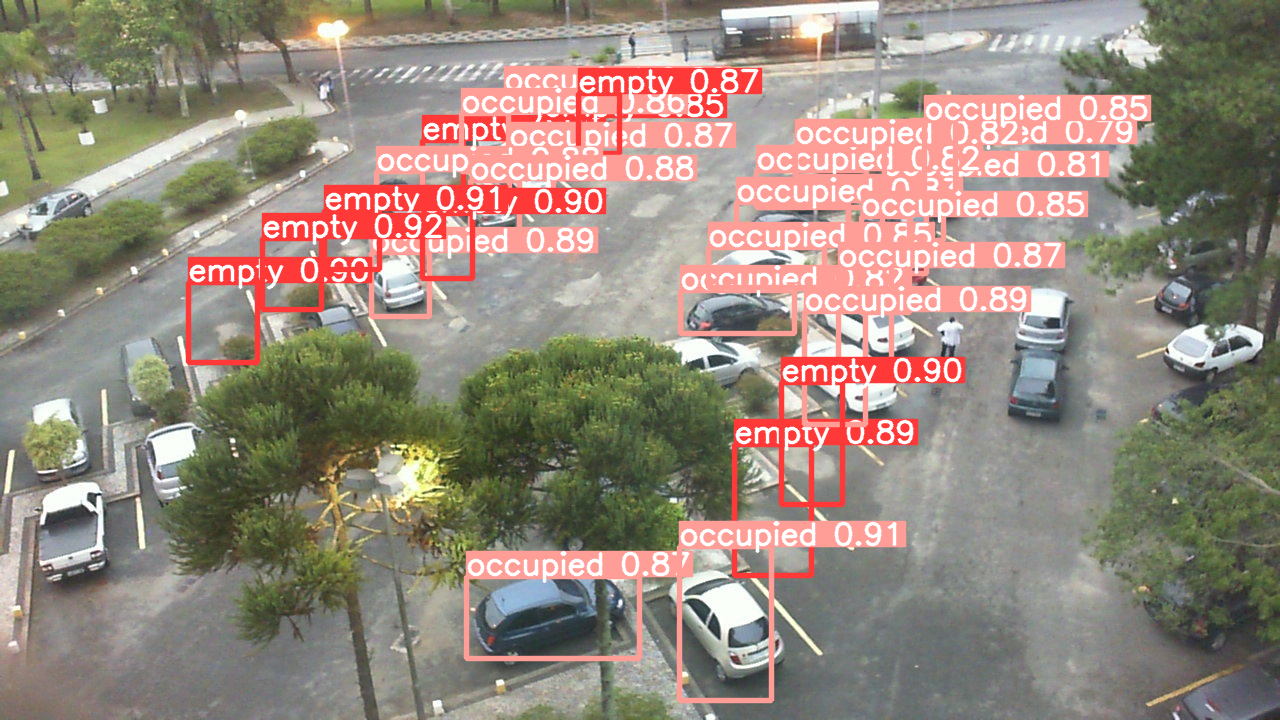

In [ ]:
test_images_directory = "./data/test/images"

image_files = [f for f in os.listdir(test_images_directory) if f.lower().endswith(".jpg")]

random_image_filename = random.choice(image_files)
random_image_path = os.path.join(test_images_directory, random_image_filename)

results = model.predict(random_image_path,save=True) # automatski sprema rez :)

result = results[0]

Image.fromarray(result.plot()[:,:,::-1]) #ovo nam treba zbog boja da su ispravne

Video nastao yolo modelom primjenjenim na cijeli video

In [ ]:
results2 = list(model.predict("./data/parkingJana.mp4",save=True,stream=True))  # u ovoj verziji vidimo rezultate za gotovi video

In [ ]:
results2 = list(model.predict("./data/parkingBruno.mp4",save=True,stream=True))  # u ovoj verziji vidimo rezultate za gotovi video

In [14]:
results2 = list(model.predict("./data/drugiKut.mp4",save=True,stream=True))  # u ovoj verziji vidimo rezultate za gotovi video


video 1/1 (1/443) /content/data/drugiKut.mp4: 384x640 1 empty, 4 occupieds, 15.3ms
video 1/1 (2/443) /content/data/drugiKut.mp4: 384x640 1 empty, 3 occupieds, 14.6ms
video 1/1 (3/443) /content/data/drugiKut.mp4: 384x640 1 empty, 3 occupieds, 15.1ms
video 1/1 (4/443) /content/data/drugiKut.mp4: 384x640 1 empty, 3 occupieds, 12.6ms
video 1/1 (5/443) /content/data/drugiKut.mp4: 384x640 1 empty, 3 occupieds, 12.6ms
video 1/1 (6/443) /content/data/drugiKut.mp4: 384x640 1 empty, 3 occupieds, 10.8ms
video 1/1 (7/443) /content/data/drugiKut.mp4: 384x640 1 empty, 3 occupieds, 12.4ms
video 1/1 (8/443) /content/data/drugiKut.mp4: 384x640 1 empty, 3 occupieds, 10.7ms
video 1/1 (9/443) /content/data/drugiKut.mp4: 384x640 1 empty, 3 occupieds, 10.8ms
video 1/1 (10/443) /content/data/drugiKut.mp4: 384x640 1 empty, 3 occupieds, 10.7ms
video 1/1 (11/443) /content/data/drugiKut.mp4: 384x640 1 empty, 3 occupieds, 10.7ms
video 1/1 (12/443) /content/data/drugiKut.mp4: 384x640 1 empty, 3 occupieds, 11.1ms


In [16]:
results2 = list(model.predict("./data/noviParking.mp4",save=True,stream=True))  # u ovoj verziji vidimo rezultate za gotovi video


video 1/1 (1/1047) /content/data/noviParking.mp4: 384x640 9 emptys, 5 occupieds, 17.7ms
video 1/1 (2/1047) /content/data/noviParking.mp4: 384x640 9 emptys, 6 occupieds, 15.0ms
video 1/1 (3/1047) /content/data/noviParking.mp4: 384x640 11 emptys, 6 occupieds, 14.8ms
video 1/1 (4/1047) /content/data/noviParking.mp4: 384x640 10 emptys, 5 occupieds, 12.1ms
video 1/1 (5/1047) /content/data/noviParking.mp4: 384x640 10 emptys, 4 occupieds, 10.8ms
video 1/1 (6/1047) /content/data/noviParking.mp4: 384x640 10 emptys, 4 occupieds, 11.2ms
video 1/1 (7/1047) /content/data/noviParking.mp4: 384x640 10 emptys, 4 occupieds, 10.8ms
video 1/1 (8/1047) /content/data/noviParking.mp4: 384x640 8 emptys, 4 occupieds, 12.6ms
video 1/1 (9/1047) /content/data/noviParking.mp4: 384x640 9 emptys, 3 occupieds, 10.8ms
video 1/1 (10/1047) /content/data/noviParking.mp4: 384x640 9 emptys, 3 occupieds, 10.8ms
video 1/1 (11/1047) /content/data/noviParking.mp4: 384x640 9 emptys, 4 occupieds, 11.2ms
video 1/1 (12/1047) /con

In [15]:
results2 = list(model.predict("./data/velikiParking.mp4",save=True,stream=True))  # u ovoj verziji vidimo rezultate za gotovi video


video 1/1 (1/233) /content/data/velikiParking.mp4: 384x640 3 emptys, 11 occupieds, 16.9ms
video 1/1 (2/233) /content/data/velikiParking.mp4: 384x640 3 emptys, 11 occupieds, 16.6ms
video 1/1 (3/233) /content/data/velikiParking.mp4: 384x640 3 emptys, 11 occupieds, 16.0ms
video 1/1 (4/233) /content/data/velikiParking.mp4: 384x640 3 emptys, 10 occupieds, 12.6ms
video 1/1 (5/233) /content/data/velikiParking.mp4: 384x640 3 emptys, 11 occupieds, 12.5ms
video 1/1 (6/233) /content/data/velikiParking.mp4: 384x640 3 emptys, 11 occupieds, 12.8ms
video 1/1 (7/233) /content/data/velikiParking.mp4: 384x640 3 emptys, 10 occupieds, 10.9ms
video 1/1 (8/233) /content/data/velikiParking.mp4: 384x640 3 emptys, 10 occupieds, 12.7ms
video 1/1 (9/233) /content/data/velikiParking.mp4: 384x640 4 emptys, 11 occupieds, 10.8ms
video 1/1 (10/233) /content/data/velikiParking.mp4: 384x640 4 emptys, 10 occupieds, 10.8ms
video 1/1 (11/233) /content/data/velikiParking.mp4: 384x640 4 emptys, 10 occupieds, 11.1ms
video 1

In [19]:
results2 = list(model.predict("./data/autoParkira.mp4",save=True,stream=True))  # u ovoj verziji vidimo rezultate za gotovi video


video 1/1 (1/1197) /content/data/autoParkira.mp4: 384x640 4 emptys, 1 occupied, 17.5ms
video 1/1 (2/1197) /content/data/autoParkira.mp4: 384x640 4 emptys, 2 occupieds, 15.3ms
video 1/1 (3/1197) /content/data/autoParkira.mp4: 384x640 4 emptys, 1 occupied, 15.5ms
video 1/1 (4/1197) /content/data/autoParkira.mp4: 384x640 4 emptys, 1 occupied, 11.4ms
video 1/1 (5/1197) /content/data/autoParkira.mp4: 384x640 4 emptys, 12.5ms
video 1/1 (6/1197) /content/data/autoParkira.mp4: 384x640 4 emptys, 1 occupied, 11.2ms
video 1/1 (7/1197) /content/data/autoParkira.mp4: 384x640 4 emptys, 10.8ms
video 1/1 (8/1197) /content/data/autoParkira.mp4: 384x640 4 emptys, 11.0ms
video 1/1 (9/1197) /content/data/autoParkira.mp4: 384x640 5 emptys, 10.7ms
video 1/1 (10/1197) /content/data/autoParkira.mp4: 384x640 5 emptys, 11.1ms
video 1/1 (11/1197) /content/data/autoParkira.mp4: 384x640 4 emptys, 10.9ms
video 1/1 (12/1197) /content/data/autoParkira.mp4: 384x640 5 emptys, 10.8ms
video 1/1 (13/1197) /content/data/a

In [ ]:
results2 = list(model.predict("./data/parkingDBK.mp4",save=True,stream=True))  # u ovoj verziji vidimo rezultate za gotovi video


video 1/1 (1/337) /content/data/parkingDBK.mp4: 384x640 1 empty, 2 occupieds, 18.5ms
video 1/1 (2/337) /content/data/parkingDBK.mp4: 384x640 1 empty, 2 occupieds, 17.0ms
video 1/1 (3/337) /content/data/parkingDBK.mp4: 384x640 1 empty, 2 occupieds, 17.4ms
video 1/1 (4/337) /content/data/parkingDBK.mp4: 384x640 1 empty, 2 occupieds, 14.0ms
video 1/1 (5/337) /content/data/parkingDBK.mp4: 384x640 2 emptys, 2 occupieds, 11.0ms
video 1/1 (6/337) /content/data/parkingDBK.mp4: 384x640 2 emptys, 2 occupieds, 11.0ms
video 1/1 (7/337) /content/data/parkingDBK.mp4: 384x640 2 emptys, 2 occupieds, 11.3ms
video 1/1 (8/337) /content/data/parkingDBK.mp4: 384x640 2 emptys, 2 occupieds, 11.0ms
video 1/1 (9/337) /content/data/parkingDBK.mp4: 384x640 2 emptys, 2 occupieds, 11.2ms
video 1/1 (10/337) /content/data/parkingDBK.mp4: 384x640 2 emptys, 3 occupieds, 11.6ms
video 1/1 (11/337) /content/data/parkingDBK.mp4: 384x640 2 emptys, 2 occupieds, 11.3ms
video 1/1 (12/337) /content/data/parkingDBK.mp4: 384x64

In [ ]:
results2 = list(model.predict("./data/parkingPrazan.mp4",save=True,stream=True))  # u ovoj verziji vidimo rezultate za gotovi video


video 1/1 (1/721) /content/data/parkingPrazan.mp4: 384x640 1 empty, 12.7ms
video 1/1 (2/721) /content/data/parkingPrazan.mp4: 384x640 (no detections), 11.8ms
video 1/1 (3/721) /content/data/parkingPrazan.mp4: 384x640 1 empty, 12.5ms
video 1/1 (4/721) /content/data/parkingPrazan.mp4: 384x640 (no detections), 11.1ms
video 1/1 (5/721) /content/data/parkingPrazan.mp4: 384x640 (no detections), 12.9ms
video 1/1 (6/721) /content/data/parkingPrazan.mp4: 384x640 (no detections), 13.2ms
video 1/1 (7/721) /content/data/parkingPrazan.mp4: 384x640 1 empty, 12.1ms
video 1/1 (8/721) /content/data/parkingPrazan.mp4: 384x640 (no detections), 12.0ms
video 1/1 (9/721) /content/data/parkingPrazan.mp4: 384x640 (no detections), 12.1ms
video 1/1 (10/721) /content/data/parkingPrazan.mp4: 384x640 (no detections), 11.2ms
video 1/1 (11/721) /content/data/parkingPrazan.mp4: 384x640 (no detections), 12.1ms
video 1/1 (12/721) /content/data/parkingPrazan.mp4: 384x640 (no detections), 23.4ms
video 1/1 (13/721) /cont

In [ ]:
results2 = list(model.predict("./data/parkingBocno.mp4",save=True,stream=True))  # u ovoj verziji vidimo rezultate za gotovi video


video 1/1 (1/626) /content/data/parkingBocno.mp4: 640x384 (no detections), 267.4ms
video 1/1 (2/626) /content/data/parkingBocno.mp4: 640x384 1 empty, 13.7ms
video 1/1 (3/626) /content/data/parkingBocno.mp4: 640x384 (no detections), 10.8ms
video 1/1 (4/626) /content/data/parkingBocno.mp4: 640x384 (no detections), 11.4ms
video 1/1 (5/626) /content/data/parkingBocno.mp4: 640x384 (no detections), 10.8ms
video 1/1 (6/626) /content/data/parkingBocno.mp4: 640x384 (no detections), 12.9ms
video 1/1 (7/626) /content/data/parkingBocno.mp4: 640x384 (no detections), 10.7ms
video 1/1 (8/626) /content/data/parkingBocno.mp4: 640x384 (no detections), 12.4ms
video 1/1 (9/626) /content/data/parkingBocno.mp4: 640x384 (no detections), 10.7ms
video 1/1 (10/626) /content/data/parkingBocno.mp4: 640x384 (no detections), 13.2ms
video 1/1 (11/626) /content/data/parkingBocno.mp4: 640x384 (no detections), 11.3ms
video 1/1 (12/626) /content/data/parkingBocno.mp4: 640x384 (no detections), 11.8ms
video 1/1 (13/626) 

Nedostatak ove metode: error kod vide velike velicine, (provjeri jos jednom onaj parking)

Video s predviđanjem po frameu koji sprema dobivene rezultate (trenutno HK)

In [ ]:
#video pretvori u slike, napravi predikciju i spremi
#lokacija videa,todo: promijeni u Janin video
video = cv2.VideoCapture('drive/MyDrive/helloKitty.mp4')

# odredi fps
fps = video.get(cv2.CAP_PROP_FPS)
print('frames per second =',fps)

In [ ]:
count=0
while video.isOpened():
    # Read a frame from the video
    success, image = video.read()

    if success:
      if count < 10:
        cnt='0'+str(count)
      else :
        cnt=count
      cv2.imwrite("./helloKitty/frame%s.jpg" % cnt, image)     # save frame as JPEG file   , probaj bez data prvo  , ok je, treba samo skontat kako napraviti rez
      #success,image = video.read() ovo je duplic
      print('Read a new frame: ', success)
      count += 1


    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
video.release()
cv2.destroyAllWindows()

In [ ]:
#helper function OVO RADI, TREBAO JE INT
import re

def myFunc(e):
  rez= re.sub(r'\D', '', e)
  print(rez)
  return int(rez)

In [ ]:
import natsort
img_array = []

# Get the list of image files in the directory
images = [img for img in os.listdir('./helloKitty') if img.endswith(".jpg")]

# Sort the images based on their filenames
images.sort(key=myFunc) #ey=myFunc  lambda f: int(filter(str.isdigit, f))

#print(images[10])

for filename in images: #glob.glob('./helloKitty/*.jpg'): # ovo su frameovi iz videa na ulazu nakon sto je predikcija primjenjena na njih
    img = cv2.imread(os.path.join('./helloKitty/', filename))
    try:
      img.shape
      print("checked for shape".format(img.shape ) + filename)
    except AttributeError:
      print("shape not found " + filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

#img_array.sort()
out = cv2.VideoWriter('helloKitty.avi',cv2.VideoWriter_fourcc(*'DIVX'), fps, size) #prije je bilo 15, ali ja imam frameove

for i in range(len(img_array)):
    out.write(img_array[i]) # provjeri
out.release()

Usporedba frame by frame i videa: zaključak

Video koji kao ulaz dobiva livestream i prikazuje rješenje u otvorenom prozoru, sredi lijepo, testiraj na laptopu

In [ ]:
video = cv2.VideoCapture(0) #ovo znaci da je iz kamere
while video.isOpened():
    # Read a frame from the video
    success, frame = video.read()

    if success:

      #success,image = video.read() ovo je duplic
      print('Read a new frame: ', success)

       # Run YOLOv8 inference on the frame
        results = model.predict(frame)

        # Visualize the results on the frame
        annotated_frame = results[0].plot()

        # Display the annotated frame
        cv2.imshow("YOLOv8 Inference", annotated_frame) #cv2.imshow() is disabled in Colab, because it causes Jupyter sessions to crash, tako da se ovo pokrece lokalno


    else:
        # Break the loop if the end of the video is reached
        break

     if cv2.waitKey(1) == ord("q"):
        break

# Release the video capture object and close the display window
video.release()
cv2.destroyAllWindows()

## Zaključak:

# Nedostatci modela i sljedeći koraci